In [1]:
'''load packages'''
import pandas as pd
import numpy as np
import os
from gensim.models import word2vec
import torch.nn as nn
import torch
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import silhouette_score

# load data

In [2]:
data=pd.read_csv('D:\\jupyter notebook\\vdjdb.txt', sep='\t')
data

,complex.id,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,...,antigen.species,reference.id,method,meta,cdr3fix,vdjdb.score,web.method,web.method.seq,web.cdr3fix.nc,web.cdr3fix.unmp
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...",2,sort,sanger,no,no
1,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2,sort,sanger,no,no
2,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEAGQGFFSNQPQHF"", ""cdr3_old"": ""C...",2,sort,sanger,no,no
3,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVPSGAGSYQLTF"", ""cdr3_old"": ""CAVPSG...",2,sort,sanger,no,no
4,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2,sort,sanger,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92766,30592,TRB,CASSPGQGGDNEQFF,TRBV7-3*01,TRBJ2-1*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSPGQGGDNEQFF"", ""cdr3_old"": ""CASSP...",0,sort,singlecell,no,no
92767,30593,TRA,CAPQGATNKLIF,TRAV12-2*01,TRAJ32*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAPQGATNKLIF"", ""cdr3_old"": ""CAPQGATN...",2,sort,singlecell,no,no
92768,30593,TRB,CASSLGAGGQETQYF,TRBV5-1*01,TRBJ2-5*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSLGAGGQETQYF"", ""cdr3_old"": ""CASSL...",2,sort,singlecell,no,no
92769,30594,TRA,CLVGGSGGYNKLIF,TRAV4*01,TRAJ4*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CLVGGSGGYNKLIF"", ""cdr3_old"": ""CLVGGS...",0,sort,singlecell,no,no


In [3]:
data=data[['complex.id', 'gene', 'cdr3', 'v.segm', 'j.segm', 'mhc.a', 'mhc.b', 'mhc.class', 'antigen.epitope', 'vdjdb.score']]

# add kmers ("kmers" column in data)

cdr： min：4  max：38  
length after k-mers = m-k+1  
**k = 3**  
需要k为不同值时：形成序列的长度范围（min，max），序列对的总个数

In [19]:
def generate_kmers(sequence, k):
    """Generate k-mers for a given sequence."""
    return [sequence[i:i+k] for i in range(len(sequence)-k+1)]
k=3 # change the k for kmers
all_kmers = [kmer for seq in data['cdr3'] for kmer in generate_kmers(seq, k)]

# Count the frequency of each 4-mer
kmer_counts = Counter(all_kmers)

In [45]:
sentence=[]
for seq in data['cdr3']:
    temp=generate_kmers(seq,k)
    sentence.append(temp)
f=open('kmer_3.txt','w')
f.writelines('\n'.join([' '.join(l) for l in sentence]))

1


In [66]:
'''add to data'''
data['kmers']=pd.Series(sentence)

C:\Users\15617\AppData\Local\Temp\ipykernel_28012\1928044982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['kmers']=pd.Series(sentence)


# visualization

model 是cdr，anti_model是antigen

### data processing method
- cdr
    - embedding
    - onehot
    - count
- antigen
    - labelencoder + k-means 
    -

### visualization for raw data: 
- cdr: embedding + flat + pca
- antigen: labelencoder

In [67]:
# load word2vec dictionary
from gensim.models import Word2Vec
model=Word2Vec.load('cdr_word2vec_10.model')
anti_model=Word2Vec.load('antigen_word2vec.model')
kmer_model=Word2Vec.load('kmer_word2vec.model')

In [34]:
def embedding(data,model):
    vec=[]
    vectors = model.wv
    length=data.map(len).max()
    for sentence in list(data):
        sentence=list(sentence)
        sentence_vector=[vectors[i] for i in sentence]
#         print(len(sentence_vector))
        while len(sentence_vector)<length:
            sentence_vector.append(np.zeros_like(vectors[sentence[0]]))
#         print(sentence_vector)
        vec.append(sentence_vector)
    return vec

In [30]:
# label cdr3 and antigen epitope (labeled cdr3 is for clustering)
le = LabelEncoder()
specificity=le.fit_transform(data['antigen.epitope'])
cdr_label=le.fit_transform(data['cdr3']) # for kmeans
data['antigen_label']=pd.Series(specificity)
data['cdr_label']=pd.Series(cdr_label)

C:\Users\15617\AppData\Local\Temp\ipykernel_28012\1818010962.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['antigen_label']=pd.Series(specificity)
C:\Users\15617\AppData\Local\Temp\ipykernel_28012\1818010962.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cdr_label']=pd.Series(cdr_label)


## embedding

In [72]:
#a chain/ b chain / combined chain
tra=data[data['gene']=='TRA']
trb=data[data['gene']=='TRB']
combined=pd.merge(tra[tra['complex.id']!=0],trb[trb['complex.id']!=0][['complex.id','cdr3','antigen.epitope']],on='complex.id')

In [32]:
# combining tra and trb
combined['cdr3']=combined['cdr3_x']+combined['cdr3_y']
combined['antigen']=combined['antigen.epitope_x']+combined['antigen.epitope_y']

In [9]:
# embedding
tra_embed=embedding(tra['cdr3'],model)
trb_embed=embedding(trb['cdr3'],model)
combd_embed=embedding(combined['cdr3'],model)

## embedding for kmers

In [74]:
#a chain/ b chain / combined chain
tra=data[data['gene']=='TRA']
trb=data[data['gene']=='TRB']
combined=pd.merge(tra[tra['complex.id']!=0],trb[trb['complex.id']!=0][['complex.id','kmers','antigen.epitope']],on='complex.id')

In [75]:
# combining tra and trb
combined['kmers']=combined['kmers_x']+combined['kmers_y']
combined['antigen']=combined['antigen.epitope_x']+combined['antigen.epitope_y']

In [76]:
# embedding for kmers
tra_embed=embedding(tra['kmers'],kmer_model)
trb_embed=embedding(trb['kmers'],kmer_model)
combd_embed=embedding(combined['kmers'],kmer_model)

In [77]:
# flatten into 2d
embed_cdr=[tra_embed,trb_embed,combd_embed]
flat_cdr=[]
for i in embed_cdr:
    flat_cdr.append([sample.flatten() for sample in torch.tensor(i).detach().numpy()])

## k means

In [54]:
from sklearn.cluster import KMeans
combined=combined.reset_index(drop=True)
combined['cdr_label']=pd.Series(le.fit_transform(combined['cdr3']))
combined['antigen_label']=pd.Series(le.fit_transform(combined['antigen']))
tra_features=tra[['cdr_label','antigen_label']]
trb_features=trb[['cdr_label','antigen_label']]
combd_features=combined[['cdr_label','antigen_label']]

### Finding the best number of clusters

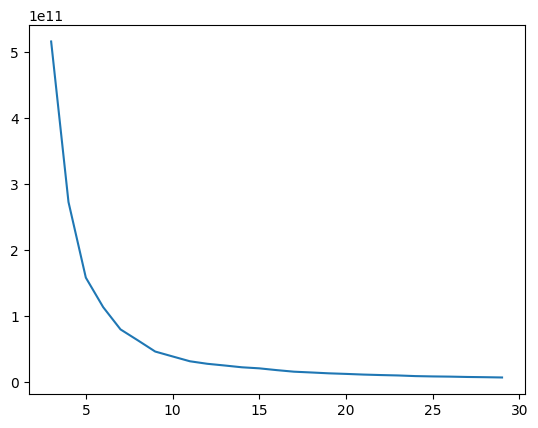

In [31]:
SSE_a = []  # 存放每次结果的误差平方和
Scores_a = []  # 存放轮廓系数
for k in range(3,30):
    kmeans = KMeans(n_clusters=k,n_init=10)  # 指定聚类簇的数量
    estimator = kmeans.fit(tra_features)
    SSE_a.append(estimator.inertia_)
    Scores_a.append(silhouette_score(np.array(tra_features), estimator.labels_, metric='euclidean'))
plt.plot(range(3,30),SSE_a)
# 5

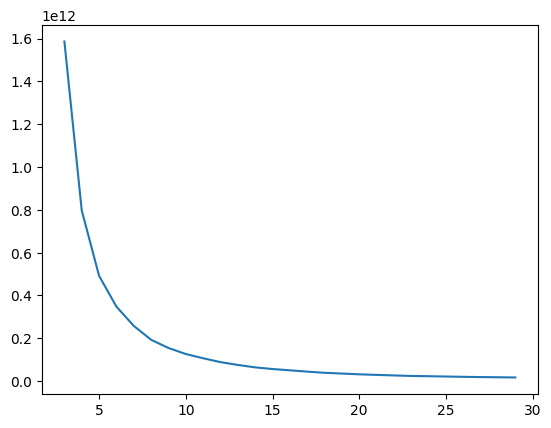

In [32]:
SSE_b = []  # 存放每次结果的误差平方和
Scores_b = []  # 存放轮廓系数
for k in range(3,30):
    kmeans = KMeans(n_clusters=k,n_init=10)  # 指定聚类簇的数量
    estimator = kmeans.fit(trb_features)
    SSE_b.append(estimator.inertia_)
    Scores_b.append(silhouette_score(np.array(trb_features), estimator.labels_, metric='euclidean'))
plt.plot(range(3,30),SSE_b)
# 4

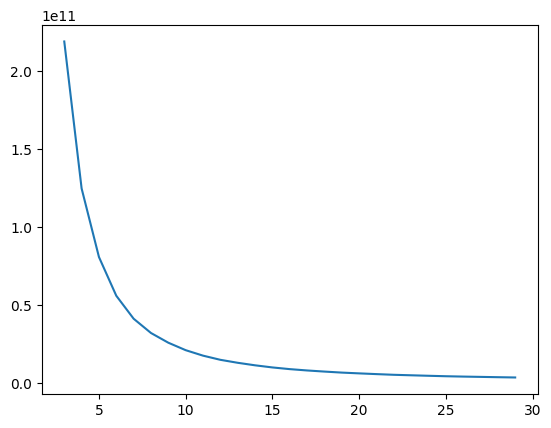

In [33]:
SSE_c = []  # 存放每次结果的误差平方和
Scores_c = []  # 存放轮廓系数
for k in range(3,30):
    kmeans = KMeans(n_clusters=k,n_init=10)  # 指定聚类簇的数量
    estimator = kmeans.fit(combd_features)
    SSE_c.append(estimator.inertia_)
    Scores_c.append(silhouette_score(np.array(combd_features), estimator.labels_, metric='euclidean'))
plt.plot(range(3,30),SSE_c)
# 4

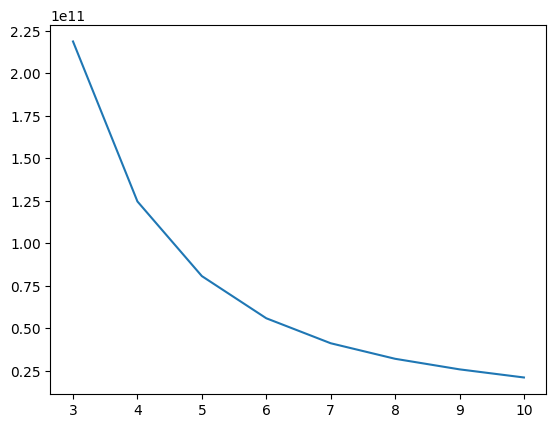

In [40]:
plt.plot(range(3,11),SSE_c[:8])

In [55]:
'''apply kmeans using selected k'''
kmeans_a = KMeans(n_clusters=5,n_init=10)
kmeans_b = KMeans(n_clusters=4,n_init=10)
kmeans_c = KMeans(n_clusters=4,n_init=10)
class_a=kmeans_a.fit_predict(tra_features)
class_b=kmeans_a.fit_predict(trb_features)
class_c=kmeans_a.fit_predict(combd_features)

# dimension reduction

In [56]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

## different model

In [57]:
tsne = TSNE(n_components=2, random_state=1,learning_rate=100)
pca = PCA(n_components=2)
Umap=umap.UMAP(random_state=42)

In [78]:
# 降维
reduced_data_list_pca = []
reduced_data_list_umap = []
reduced_data_list_tsne = []
for flattened_datas in flat_cdr:
    # UMAP
    # reduced_data = Umap.fit_transform(flattened_datas)
    reduced_data_list_umap.append(Umap.fit_transform(flattened_datas))
    # tSNE
    # reduced_data = tsne.fit_transform(flattened_datas)
    reduced_data_list_tsne.append(tsne.fit_transform(np.array(flattened_datas)))
    # PCA
    # reduced_data = pca.fit_transform(flattened_datas)
    reduced_data_list_pca.append(pca.fit_transform(flattened_datas))

D:\python39\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
D:\python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\python39\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
D:\python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\python39\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no

In [59]:
le = LabelEncoder()
tra_specificity=le.fit_transform(tra['antigen.epitope'])

In [13]:
n_antigens = len(set(tra['antigen.epitope']))
cmap = plt.cm.get_cmap('viridis', n_antigens)

## plot for normal embedding

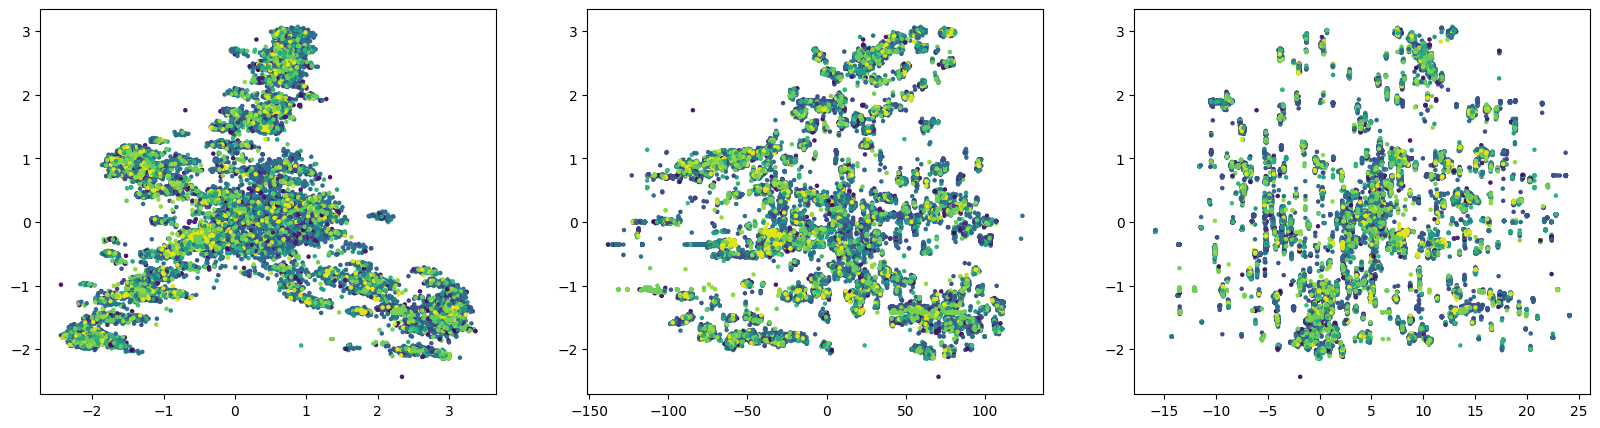

In [49]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.scatter(tra_reduction[:, 0], tra_reduction[:, 1], c = tra_specificity, marker='.', s = 20)
plt.subplot(132)
plt.scatter(tra_reduction1[:, 0], tra_reduction[:, 1], c = tra_specificity, marker='.', s = 20)
plt.subplot(133)
plt.scatter(tra_reduction_umap[:, 0], tra_reduction[:, 1], c = tra_specificity, marker='.', s = 20)

## after kmeans

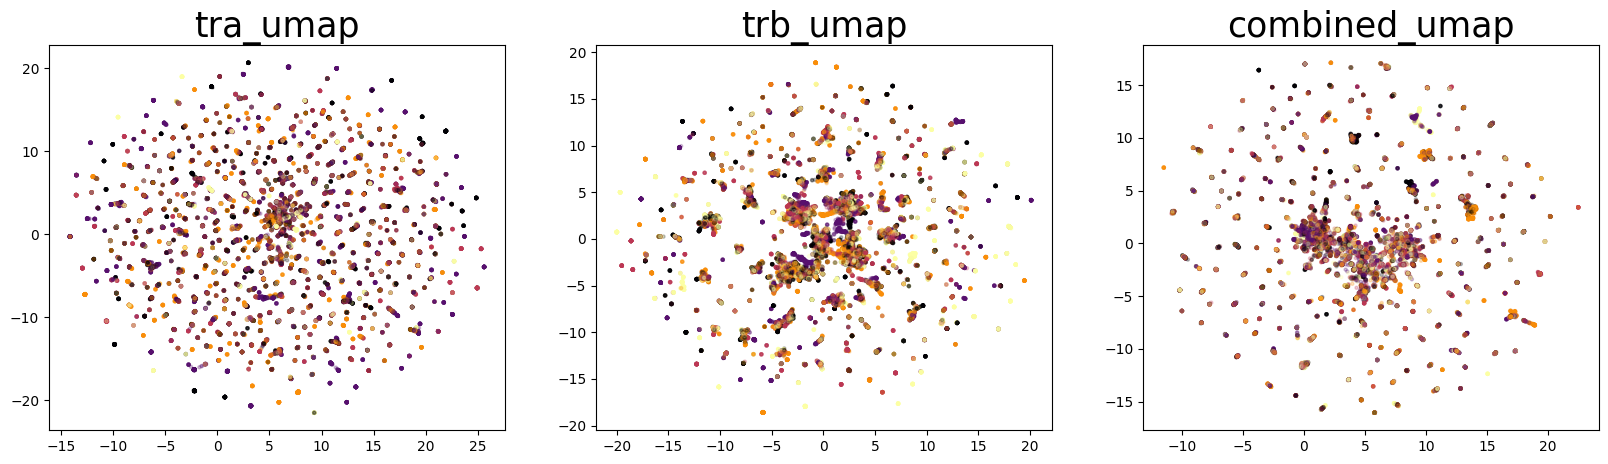

In [82]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(reduced_data_list_umap[0][:, 0], reduced_data_list_umap[0][:, 1], c = class_a, cmap='inferno',
            marker='.', s = 20, alpha = 1/4)
plt.title('tra_umap',fontsize=25)
plt.subplot(1, 3, 2)
plt.scatter(reduced_data_list_umap[1][:, 0], reduced_data_list_umap[1][:, 1], c = class_b, cmap='inferno',
            marker='.', s = 20, alpha = 1/4)
plt.title('trb_umap',fontsize=25)
plt.subplot(1, 3, 3)
plt.scatter(reduced_data_list_umap[2][:, 0], reduced_data_list_umap[2][:, 1], c = class_c, cmap='inferno',
            marker='.', s = 20, alpha = 1/4)
plt.title('combined_umap',fontsize=25)
plt.savefig("umap_kmers.png")

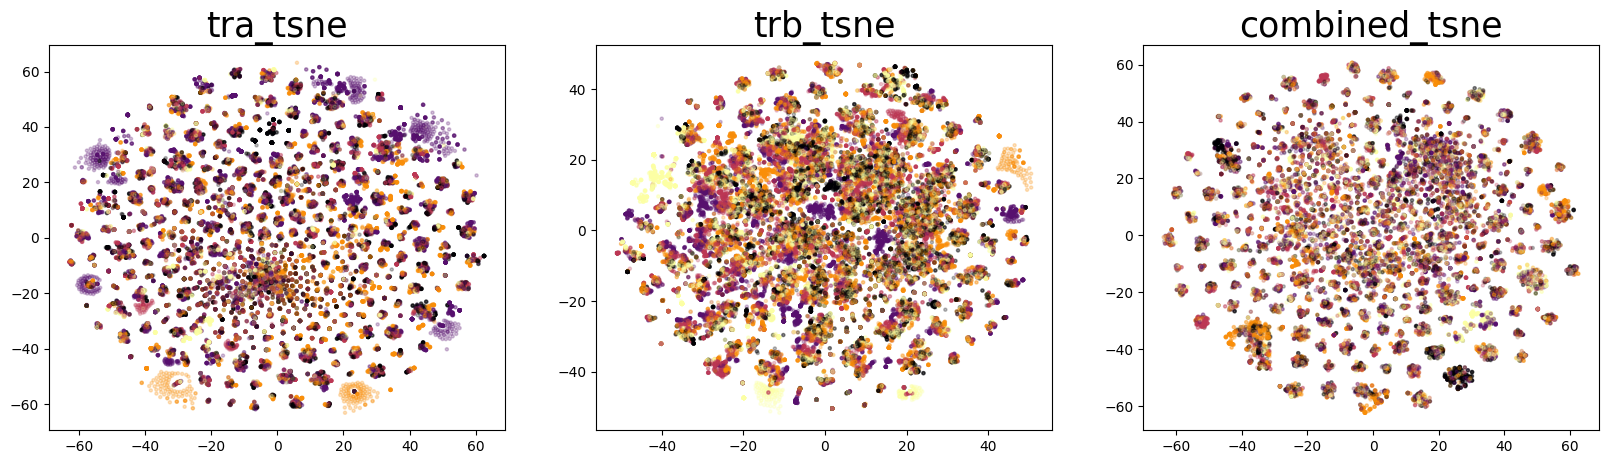

In [83]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(reduced_data_list_tsne[0][:, 0], reduced_data_list_tsne[0][:, 1], c = class_a, cmap='inferno',
            marker='.', s = 20, alpha = 1/4)
plt.title('tra_tsne',fontsize=25)
plt.subplot(1, 3, 2)
plt.scatter(reduced_data_list_tsne[1][:, 0], reduced_data_list_tsne[1][:, 1], c = class_b, cmap='inferno',
            marker='.', s = 20, alpha = 1/4)
plt.title('trb_tsne',fontsize=25)
plt.subplot(1, 3, 3)
plt.scatter(reduced_data_list_tsne[2][:, 0], reduced_data_list_tsne[2][:, 1], c = class_c, cmap='inferno',
            marker='.', s = 20, alpha = 1/4)
plt.title('combined_tsne',fontsize=25)
plt.savefig("tsne_kmers.png")

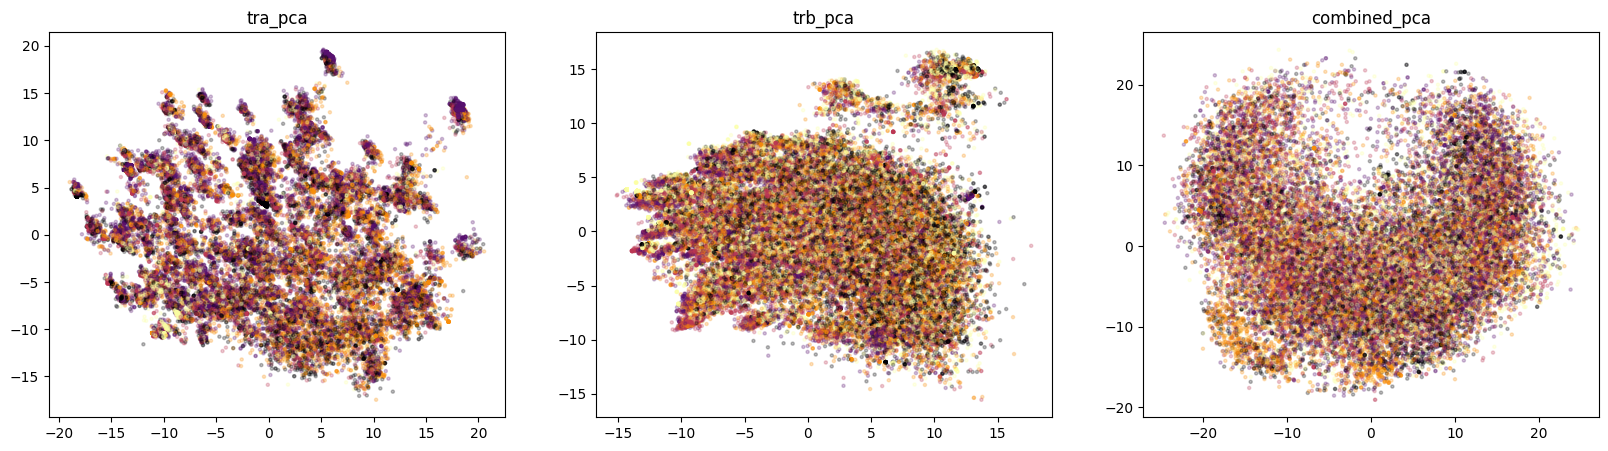

In [84]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(reduced_data_list_pca[0][:, 0], reduced_data_list_pca[0][:, 1], c = class_a, cmap='inferno',
            marker='.', s = 20, alpha = 1/4)
plt.title('tra_pca')
plt.subplot(1, 3, 2)
plt.scatter(reduced_data_list_pca[1][:, 0], reduced_data_list_pca[1][:, 1], c = class_b, cmap='inferno',
            marker='.', s = 20, alpha = 1/4)
plt.title('trb_pca')
plt.subplot(1, 3, 3)
plt.scatter(reduced_data_list_pca[2][:, 0], reduced_data_list_pca[2][:, 1], c = class_c, cmap='inferno',
            marker='.', s = 20, alpha = 1/4)
plt.title('combined_pca')
plt.savefig("pca_kmers.png")

# test + data insight (ignore this)

In [25]:
data['cdr_vec']=pd.Series(sentence_vectors)

C:\Users\15617\AppData\Local\Temp\ipykernel_32448\3589597546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cdr_vec']=pd.Series(sentence_vectors)


In [29]:
word_vectors = model.wv

# 新建一个 DataFrame 用于存储每个句子
sentence_df_list = []

# 遍历句子并生成每个句子的 DataFrame
for idx, sentence in enumerate(sentences):
    # 创建一个新的 DataFrame
    sentence_df = pd.DataFrame(sentence, columns=['word'])
    # 添加句子索引列
    sentence_df['sentence_index'] = idx
    # 将单词转换为词向量并添加到 DataFrame 中
    sentence_df['word_vector'] = sentence_df['word'].apply(lambda word: word_vectors[word] if word in word_vectors else None)
    # 将当前句子 DataFrame 加入列表中
    sentence_df_list.append(sentence_df)

# 将所有句子 DataFrame 连接成一个大的 DataFrame
all_sentence_df = pd.concat(sentence_df_list, ignore_index=True)

# 将句子 DataFrame 与原始 DataFrame 进行连接
merged_df = pd.merge(data, all_sentence_df, on='sentence_index', how='left')

KeyError: 'sentence_index'

In [27]:
len(sentence_vectors)

131

In [26]:
data

,complex.id,gene,cdr3,v.segm,j.segm,mhc.a,mhc.b,mhc.class,antigen.epitope,vdjdb.score,cdr_vec
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HLA-B*08,B2M,MHCI,FLKEKGGL,2,"[tensor(0.1607), tensor(0.1427), tensor(-0.051..."
1,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HLA-B*08,B2M,MHCI,FLKEKGGL,2,"[tensor(0.1584), tensor(0.1533), tensor(-0.041..."
2,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HLA-B*08,B2M,MHCI,FLKEKGGL,2,"[tensor(0.1565), tensor(0.1579), tensor(-0.025..."
3,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HLA-B*08,B2M,MHCI,FLKEKGGL,2,"[tensor(0.1546), tensor(0.1490), tensor(-0.047..."
4,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HLA-B*08,B2M,MHCI,FLKEKGGL,2,"[tensor(0.1582), tensor(0.1488), tensor(-0.043..."
...,...,...,...,...,...,...,...,...,...,...,...
92766,30592,TRB,CASSPGQGGDNEQFF,TRBV7-3*01,TRBJ2-1*01,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,0,NaN
92767,30593,TRA,CAPQGATNKLIF,TRAV12-2*01,TRAJ32*01,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,2,NaN
92768,30593,TRB,CASSLGAGGQETQYF,TRBV5-1*01,TRBJ2-5*01,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,2,NaN
92769,30594,TRA,CLVGGSGGYNKLIF,TRAV4*01,TRAJ4*01,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,0,NaN


In [10]:
# 将词向量作为embedding层的初始值
weights = torch.FloatTensor(model.wv.vectors)
embedding= nn.Embedding.from_pretrained(embeddings=weights, freeze=False)
# 构建词典
idx2word ={ i:k for i,k in enumerate(model.wv.key_to_index.keys())}
word2idx ={ k:i for i,k in enumerate(model.wv.key_to_index.keys())}

In [14]:
embedding(sentences)

TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not Text8Corpus

In [3]:
data.head().to_csv('vdjsample.csv')

In [4]:
nopair=data[data['complex.id']==0]

In [5]:
nopair['species'].value_counts()

HomoSapiens      28641
MacacaMulatta     2119
MusMusculus        823
Name: species, dtype: int64

In [8]:
data.groupby(by=['species','gene'])['complex.id'].count()

species        gene
HomoSapiens    TRA     35643
               TRB     49686
MacacaMulatta  TRA        87
               TRB      2032
MusMusculus    TRA      2319
               TRB      3004
Name: complex.id, dtype: int64

In [24]:
word_vectors = model.wv
# 获取句子的词向量并形成句子矩阵
sentence_vectors = []
for sentence in sentences:
    # 对于每个句子，获取其词向量并计算平均值
    word_count = 0
    sentence_vector = torch.zeros(model.vector_size)  # 初始化句子向量为全零向量
    for word in sentence:
        if word in word_vectors:
            word_count += 1
            sentence_vector += torch.tensor(word_vectors[word])
    # 计算句子向量的平均值
    if word_count > 0:
        sentence_vector /= word_count
    sentence_vectors.append(sentence_vector)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92771 entries, 0 to 92770
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   complex.id        92771 non-null  int64 
 1   gene              92771 non-null  object
 2   cdr3              92771 non-null  object
 3   v.segm            92670 non-null  object
 4   j.segm            91626 non-null  object
 5   species           92771 non-null  object
 6   mhc.a             92771 non-null  object
 7   mhc.b             92771 non-null  object
 8   mhc.class         92771 non-null  object
 9   antigen.epitope   92771 non-null  object
 10  antigen.gene      92709 non-null  object
 11  antigen.species   92771 non-null  object
 12  reference.id      91260 non-null  object
 13  method            92771 non-null  object
 14  meta              92771 non-null  object
 15  cdr3fix           92771 non-null  object
 16  vdjdb.score       92771 non-null  int64 
 17  web.method  

In [4]:
data.head()

,complex.id,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,...,antigen.species,reference.id,method,meta,cdr3fix,vdjdb.score,web.method,web.method.seq,web.cdr3fix.nc,web.cdr3fix.unmp
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...",2,sort,sanger,no,no
1,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2,sort,sanger,no,no
2,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEAGQGFFSNQPQHF"", ""cdr3_old"": ""C...",2,sort,sanger,no,no
3,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVPSGAGSYQLTF"", ""cdr3_old"": ""CAVPSG...",2,sort,sanger,no,no
4,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2,sort,sanger,no,no


In [5]:
data['complex.id'].value_counts()

0        31583
9518         2
3435         2
1386         2
7529         2
         ...  
12947        2
14994        2
8849         2
10896        2
2047         2
Name: complex.id, Length: 30595, dtype: int64

In [6]:
data['cdr3'].value_counts()

CASSIRSSYEQYF         361
CAASETSYDKVIF         157
CASSWGGGSHYGYTF       154
CAIGPGNMLTF           153
CAGGGSQGNLIF          144
                     ... 
CASSPAGFSGGATDTQYF      1
CASAITGGSSAEQYF         1
CSARGVEGYEQYF           1
CASAGFSVNEQFF           1
CASSAPDSYEQYF           1
Name: cdr3, Length: 68994, dtype: int64

In [3]:
data['mhc.a'].value_counts()

HLA-A*03:01       29264
HLA-A*02:01       16511
HLA-A*02          15053
HLA-A*11:01        5433
HLA-B*08:01        2961
                  ...  
HLA-C*08:02:12        2
HLA-B*14:02           1
HLA-A*32:01           1
HLA-B*52:01           1
HLA-C*04:01           1
Name: mhc.a, Length: 119, dtype: int64

In [4]:
data['mhc.b'].value_counts()

B2M                     88368
HLA-DRB1*01              1215
HLA-DPB*04:01             937
HLA-DRB5*01:01            348
HLA-DQB1*02:01            328
HLA-DRB1*15               311
HLA-DRB1*04:01            288
HLA-DRB1*11:01            218
HLA-DRA*01:01             119
HLA-DRB1*07:01            113
HLA-DRB1*15:01            112
HLA-DRB1*01:01            101
H-2Aa                      38
HLA-DPB1*04:01             38
HLA-DRB1*15:02             29
HLA-DQB1*06:01             18
HLA-DQB1*03:02:12          18
HLA-DPB1*13:01             16
H-2Eb1                     14
HLA-DRB1*01:01:01          14
HLA-DQB1*03:02             12
HLA-DQB1*06:02             12
HLA-DQB1*02:01:08          12
HLA-DRB1*04:01:01          10
HLA-DRB1*03:01             10
HLA-DRB1*15:03              8
HLA-DRB3*03:01              8
HLA-DQB1*05:01:01:03        6
HLA-DQB1*03:01              6
HLA-DQB1*02                 6
HLA-DQB1*02:02:01:01        4
HLA-DRB1*15:01:01:04        4
HLA-DRB3*02:02              4
HLA-DRB1*1

In [5]:
data['mhc.class'].value_counts()

MHCI     88368
MHCII     4403
Name: mhc.class, dtype: int64

In [6]:
data['antigen.gene'].value_counts()

IE1       28150
M         10099
pp65       9331
EBNA4      5032
Spike      4507
          ...  
PHLPP1        1
RNF213        1
CDKN2A        1
RNF10         1
SNX24         1
Name: antigen.gene, Length: 268, dtype: int64

In [15]:
data['antigen.species'].value_counts()

CMV                          38345
InfluenzaA                   15182
EBV                          11440
SARS-CoV-2                   10133
HomoSapiens                   5095
HIV-1                         3554
HCV                           2359
SIV                           2119
MCMV                          1463
YFV                            789
Wheat                          301
PlasmodiumBerghei              245
HTLV-1                         234
DENV1                          182
DENV3/4                        179
HIV                            162
HSV-2                          154
LCMV                           151
RSV                            125
synthetic                       92
VSV                             66
M.tuberculosis                  64
DENV2                           60
HCoV-HKU1                       57
TriticumAestivum                53
MusMusculus                     50
HPV                             28
GallusGallus                    16
AdV                 

In [7]:
data['reference.id'].value_counts()

https://www.10xgenomics.com/resources/application-notes/a-new-way-of-exploring-immunity-linking-highly-multiplexed-antigen-recognition-to-immune-repertoire-and-phenotype/#    40716
PMID:28423320                                                                                                                                                                  10189
PMID:28636592                                                                                                                                                                   5066
PMID:34793243                                                                                                                                                                   4341
https://github.com/antigenomics/vdjdb-db/issues/193                                                                                                                             2486
                                                                                               

In [8]:
data['vdjdb.score'].value_counts()

0    80357
1     8329
2     2336
3     1749
Name: vdjdb.score, dtype: int64

In [9]:
data['web.method.seq'].value_counts()

singlecell    61602
amplicon      19864
sanger        10466
other           839
Name: web.method.seq, dtype: int64

In [10]:
data['web.cdr3fix.nc'].value_counts()

no     92337
yes      434
Name: web.cdr3fix.nc, dtype: int64

In [14]:
data[data['web.cdr3fix.nc']=='yes'].head().to_csv('nc.csv')

In [16]:
data['cdr3'].apply(len).max()

38

In [17]:
data['cdr3'].apply(len).min()

4